# Investigate if numeric encoding can lead to a smoother response surface.

## Main Questions

* Do we get a more smooth response surface, if we use
    * numeric input encoding
    * use narrow network

In [37]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from aimanager.utils.utils import make_dir
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

run = 'y_encoding_2'

folder = f'../../data/training/{run}/train'
merged_folder = f'../../data/training/{run}/merged'
bs_folder = f'../../data/training/baselines'
bs_merged_folder = f'../../data/training/baselines_merged'

plot_folder = f'plots/{run}'

make_dir(plot_folder)
make_dir(merged_folder)
make_dir(bs_merged_folder)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
file_names = ['metrics.parquet', 'confusion_matrix.parquet', 'synthetic_predicitions.parquet']

def get_df(file_name, merged_folder, folder):
    m_file = os.path.join(merged_folder, file_name)
    if not os.path.isfile(m_file):
        df = merge_files_by_name(folder, file_name)
        df.to_parquet(m_file)
        return df
    else:
        return pd.read_parquet(m_file)

metrics_df, confusion_matrix_df, synthethetic_df = (
    get_df(file_name, merged_folder, folder)
    for file_name in file_names
)

baseline_df = get_df(file_names[0], bs_merged_folder, bs_folder)

In [3]:
baseline_df

,name,value,cv_split,epoch,set,baseline
0,loss,3.053400,0,0,None,NaN
1,mean_absolute_error,7.679183,0,0,train,NaN
2,accuracy,0.030038,0,0,train,NaN
3,mean_absolute_error,7.546326,0,0,test,NaN
4,accuracy,0.012780,0,0,test,NaN
...,...,...,...,...,...,...
9995,loss,1.749402,19,990,None,onehot_mlp
9996,mean_absolute_error,3.049074,19,990,train,onehot_mlp
9997,accuracy,0.492141,19,990,train,onehot_mlp
9998,mean_absolute_error,3.331210,19,990,test,onehot_mlp


In [4]:
labels = list(set(metrics_df.columns) - set(['name', 'value', 'cv_split', 'epoch', 'set']))
print(labels)

metrics_df['label'] = ''
bw = ''
for l in labels:
    metrics_df['label'] += (bw + l + ':') + metrics_df[l].astype(str)
    bw = ' '

to_string = ['layers', 'hidden_size']
to_string = list(set(to_string).intersection(set(metrics_df.columns)))
if len(to_string) > 0:
    metrics_df[to_string] = metrics_df[to_string].astype(str)
    synthethetic_df[to_string] = synthethetic_df[to_string].astype(str)
    confusion_matrix_df[to_string] = confusion_matrix_df[to_string].astype(str)

['strategy', 'y_encoding', 'lr']


In [5]:
w = (
    (baseline_df['set'] == 'test') & 
    (baseline_df['epoch'] == 990)
)

df = baseline_df[w]

baseline = df.groupby(['baseline', 'name'])['value'].median()
baseline

baseline    name               
onehot_mlp  accuracy               0.489901
            mean_absolute_error    2.959608
Name: value, dtype: float64

## Overview

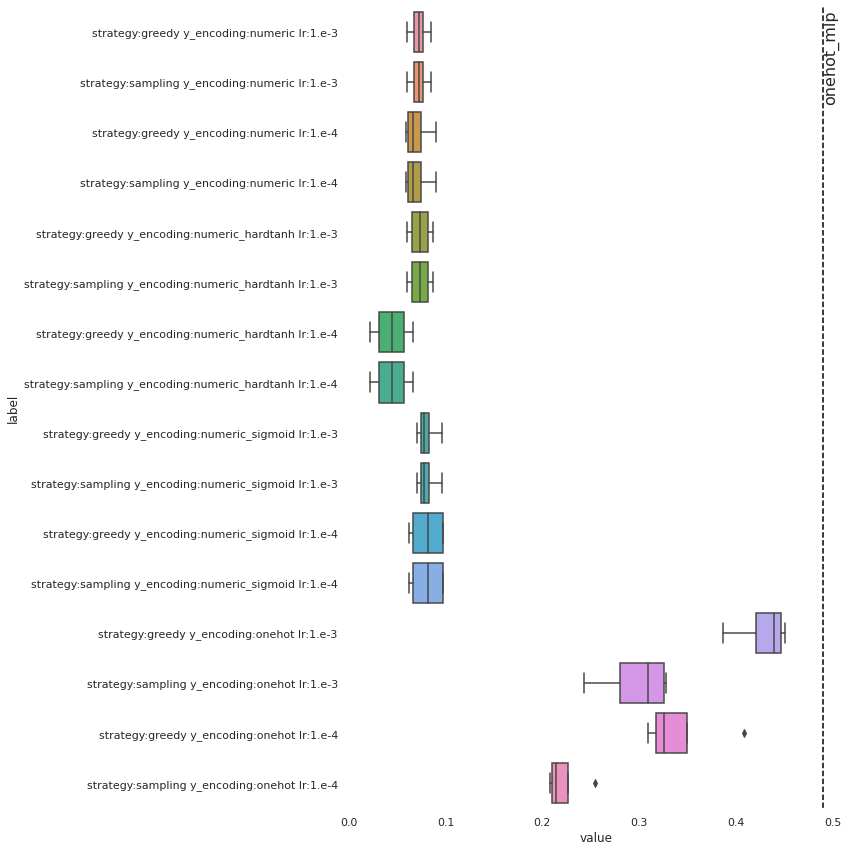

In [6]:
metric_name = 'accuracy'

w = (
    (metrics_df['name'] == metric_name) &
    (metrics_df['set'] == 'test') & 
    # (metrics_df['layers'] == '3') & 
    # (metrics_df['hidden_size'] == '20') & 
    # (metrics_df['lr'] == '1.e-3') & 
    # (metrics_df['y_encoding'] != 'numeric') & 
    (metrics_df['epoch'] == 990)
)
df = metrics_df[w]
# df['y_ordinal'] = df['y_ordinal'].astype(str)
df = df.sort_values(['y_encoding',  'lr'])
sns.catplot(data=df, x='value', y='label', orient='h', kind='box', sharex=False, height=12)

for idx, dfg in baseline.groupby(level=0):
    plt.axvline(dfg[(idx, metric_name)], color='black', ls='--')
    plt.text(dfg[(idx, metric_name)], 0.5, idx, rotation=90, size=16, va='center')

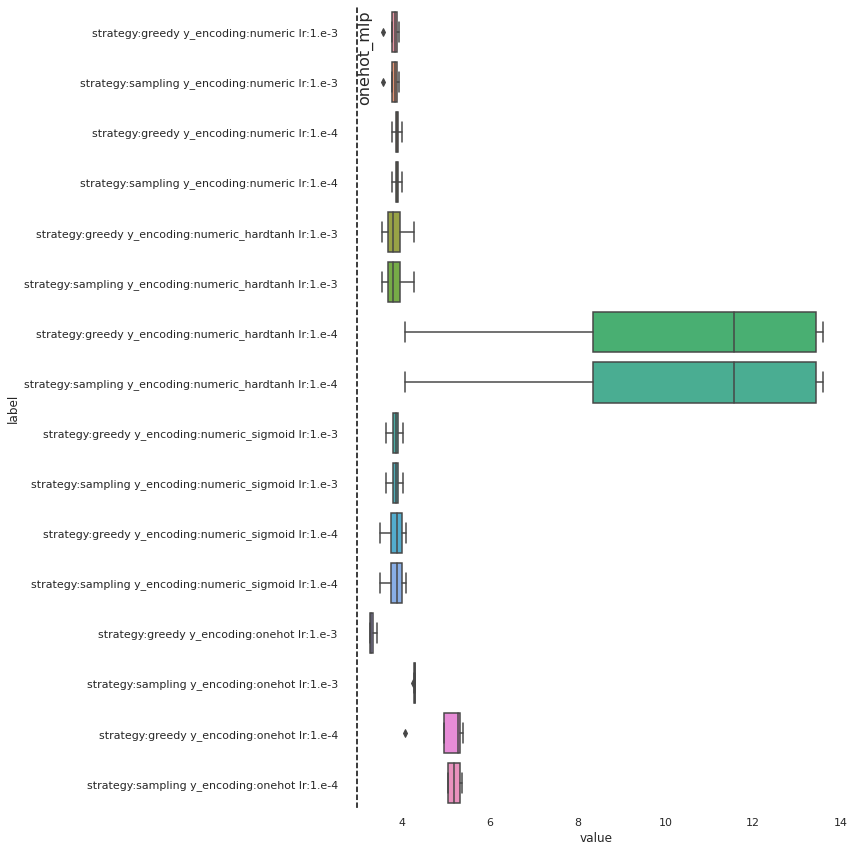

In [14]:
metric_name = 'mean_absolute_error'

w = (
    (metrics_df['name'] == metric_name) &
    (metrics_df['set'] == 'test') & 
    # (metrics_df['layers'] == '3') & 
    # (metrics_df['hidden_size'] == '20') & 
    # (metrics_df['lr'] == '1.e-3') & 
    # (metrics_df['y_encoding'] != 'numeric') & 
    (metrics_df['epoch'] == 990)
)
df = metrics_df[w]
# df['y_ordinal'] = df['y_ordinal'].astype(str)
df = df.sort_values(['y_encoding',  'lr'])
sns.catplot(data=df, x='value', y='label', orient='h', kind='box', sharex=False, height=12)

for idx, dfg in baseline.groupby(level=0):
    plt.axvline(dfg[(idx, metric_name)], color='black', ls='--')
    plt.text(dfg[(idx, metric_name)], 0.5, idx, rotation=90, size=16, va='center')

### First conclusion

* Hugh variance in the performance
* Numeric encoding has clearly lower performance

## Statistical analysis of grid

In [15]:
label_ref = {
    # 'regularisation': 'none',
    'y_encoding': 'onehot',
    'x_encoding': 'numeric',
    'layers': 2,
    'hidden_size': 5,
    'lr': '1.e-4'
}

label_str = [f"C({l}, Treatment(reference='{label_ref[l]}'))" if l in label_ref else l for l in labels]

In [16]:
w = (
    (metrics_df['name'] == 'accuracy') &
    (metrics_df['set'] == 'test') &
    (metrics_df['strategy'] == 'sampling') & 
    # (metrics_df['layers'] == '2') & 
    (metrics_df['epoch'] == 990)
)
df = metrics_df[w]

m_str = [f'{a}*{b}' for a in label_str for b in label_str]

results = smf.glm(f"value ~ {'+'.join(m_str)}", data=df).fit()
results_df = results.summary2().tables[1]

print('metric accuracy - positive coef -> better')
results_df[results_df['P>|z|'] < 0.25].sort_values('P>|z|')


metric accuracy - positive coef -> better


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,0.222604,0.010252,21.713037,1.545044e-104,0.202510,0.242698
"C(y_encoding, Treatment(reference='onehot'))[T.numeric_hardtanh]",-0.178492,0.014499,-12.310983,7.905410e-35,-0.206909,-0.150076
"C(y_encoding, Treatment(reference='onehot'))[T.numeric]",-0.152380,0.014499,-10.509926,7.775480e-26,-0.180796,-0.123963
"C(y_encoding, Treatment(reference='onehot'))[T.numeric_sigmoid]",-0.141638,0.014499,-9.769074,1.528422e-22,-0.170055,-0.113221
"C(lr, Treatment(reference='1.e-4'))[T.1.e-3]",0.074594,0.014499,5.144893,2.676740e-07,0.046177,0.103011
"C(y_encoding, Treatment(reference='onehot'))[T.numeric_sigmoid]:C(lr, Treatment(reference='1.e-4'))[T.1.e-3]",-0.075224,0.020504,-3.668707,2.437802e-04,-0.115411,-0.035036
"C(y_encoding, Treatment(reference='onehot'))[T.numeric]:C(lr, Treatment(reference='1.e-4'))[T.1.e-3]",-0.072483,0.020504,-3.535049,4.076996e-04,-0.112671,-0.032296
"C(y_encoding, Treatment(reference='onehot'))[T.numeric_hardtanh]:C(lr, Treatment(reference='1.e-4'))[T.1.e-3]",-0.045255,0.020504,-2.207098,2.730723e-02,-0.085442,-0.005067


### Accuracy

#### Strong evidence
* larger learning rate (1.e-3) is better
* ordinal x encoding (and to a lesser extend onehot) is better then numeric encoding
* higher number of neurons is better for onehot encodingß

In [17]:
w = (
    (metrics_df['name'] == 'mean_absolute_error') &
    (metrics_df['set'] == 'test') &
    (metrics_df['strategy'] == 'sampling') &
    (metrics_df['epoch'] == 990)
)
df = metrics_df[w]

m_str = [f'{a}*{b}' for a in label_str for b in label_str]

results = smf.glm(f"value ~ {'+'.join(m_str)}", data=df).fit()
results_df = results.summary2().tables[1]

print('metric mean_absolute_error - negative coef -> better')
results_df[results_df['P>|z|'] < 0.10].sort_values('P>|z|')

metric mean_absolute_error - negative coef -> better


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,5.185035,0.792757,6.540511,6.130884e-11,3.631260,6.738810
"C(y_encoding, Treatment(reference='onehot'))[T.numeric_hardtanh]",5.013597,1.121127,4.471924,7.751902e-06,2.816227,7.210966
"C(y_encoding, Treatment(reference='onehot'))[T.numeric_hardtanh]:C(lr, Treatment(reference='1.e-4'))[T.1.e-3]",-5.450726,1.585514,-3.437829,5.863970e-04,-8.558275,-2.343176


### mean absolute error

#### Strong evidence
* ordinal > numeric
* hidden 20 > hidden 5

## Best parameters

In [18]:
# w = (
#     (metrics_df['x_encoding'] == 'numeric')
# )
# df = metrics_df[w]
df = metrics_df

best_labels = {}
for m in ['mean_absolute_error', 'accuracy']:
    df = df.reset_index(drop=True)
    gb_col = list(set(df.columns) - set(['cv_split', 'value']))
    df_g = df.groupby(gb_col)['value'].median().reset_index()
    df_g = df_g.dropna(subset='value')
    w = (
        (df_g['name'] == m) &
        (df_g['set'] == 'test')
    )
    if m == 'mean_absolute_error':
        best = df_g.loc[df_g[w]['value'].idxmin()]
    else:
        best = df_g.loc[df_g[w]['value'].idxmax()]
    best_labels[m] = {l: best[l] for l in labels}

    print(f'Best performance for metric {m} is {best.label}.')
    w = (
        (df_g['label'] == best.label) &
        (df_g['epoch'] == 990)
    )

    print(df_g.loc[w, ['name', 'set', 'value']])
    print('================')
    # print(f'Best performance for metric {m} with a value of {best.value} is {best.label} in epoch {best.epoch}')



Best performance for metric mean_absolute_error is strategy:greedy y_encoding:onehot lr:1.e-3.
                     name    set     value
6360             accuracy   test  0.439323
6361             accuracy  train  0.427960
6362  mean_absolute_error   test  3.289324
6363  mean_absolute_error  train  3.332955
Best performance for metric accuracy is strategy:greedy y_encoding:onehot lr:1.e-3.
                     name    set     value
6360             accuracy   test  0.439323
6361             accuracy  train  0.427960
6362  mean_absolute_error   test  3.289324
6363  mean_absolute_error  train  3.332955


### Summary

* We have the highest accuracy and mae for
    * low regularisation 
    * hidden_size of 20
    * learning rate of 1.e-3
    * x-encoding onehot
* 3 layer is leading to a better mae, 2 layer to a higher accuracy

## Investigation of particular parameter

### Hidden Size and number of layer

strategy=greedy|epoch=990


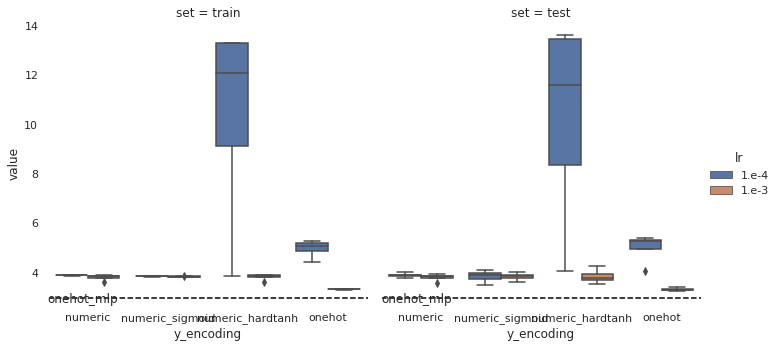

In [19]:
selection = best_labels['mean_absolute_error'].copy()

focus = ['y_encoding', 'lr']
metric_name = 'mean_absolute_error'

for f in focus:
    selection.pop(f)
selection['epoch'] = 990

w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

fg = sns.catplot(data=metrics_df[w1 & w2], x=focus[0], hue=focus[1], y='value', col='set', kind='box', sharey=True)

for idx, dfg in baseline.groupby(level=0):
    for ax in fg.axes_dict.values():
        ax.axhline(dfg[(idx, metric_name)], color='black', ls='--')
        ax.text(-0.5, dfg[(idx, metric_name)]*0.99,  idx, rotation=0, size=12, va='center')

print('|'.join(f'{k}={v}' for k, v in selection.items()))

#### Results

* Number of layers has a relative small effect on mae
* Number of hidden units has a large effect on the training set and a small effect on the test set (overfitting!)

## Confusion Matrix

/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


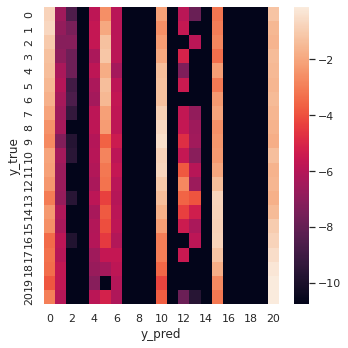

In [50]:
selection = best_labels['accuracy'].copy()

w = confusion_matrix_df['set'] == 'test'

df = confusion_matrix_df[w].copy()

focus_dimensions = ['y_encoding', 'strategy']
# focus_dimensions = []

for fd in focus_dimensions:
    selection.pop(fd)
# selection['regularisation'] = 'wd_1.e-6'

w = pd.concat(
    (df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

df = df[w]

# w2 = df[focus_dimension].isin(['none', 'wd_1.e-3', 'wd_1.e-4'])
# df = df[w2]

df = df.sort_values(focus_dimensions)

def _plot_heatmap(data, x, y, values):
    dfg = data.groupby([x,y])[values].sum().reset_index()
    dfg[values] = dfg[values] / dfg.groupby([x])[values].transform('sum')
    # dfg = dfg.reset_index()
    cm = dfg.pivot_table(index=x, columns=y, values=values)
    # print(cm)
    cm = np.log(cm)
    cm = cm.replace([np.inf, -np.inf], np.nan)
    cm = cm.fillna(cm.min().min())
    sns.heatmap(cm)

plot_heatmap = lambda data, color: _plot_heatmap(
    data, x='y_true',y='y_pred', values='value')

col_row = {k: v for k, v in zip(['col', 'row'], focus_dimensions)}

fg = sns.FacetGrid(df, height=5, **col_row)
fg.map_dataframe(plot_heatmap)

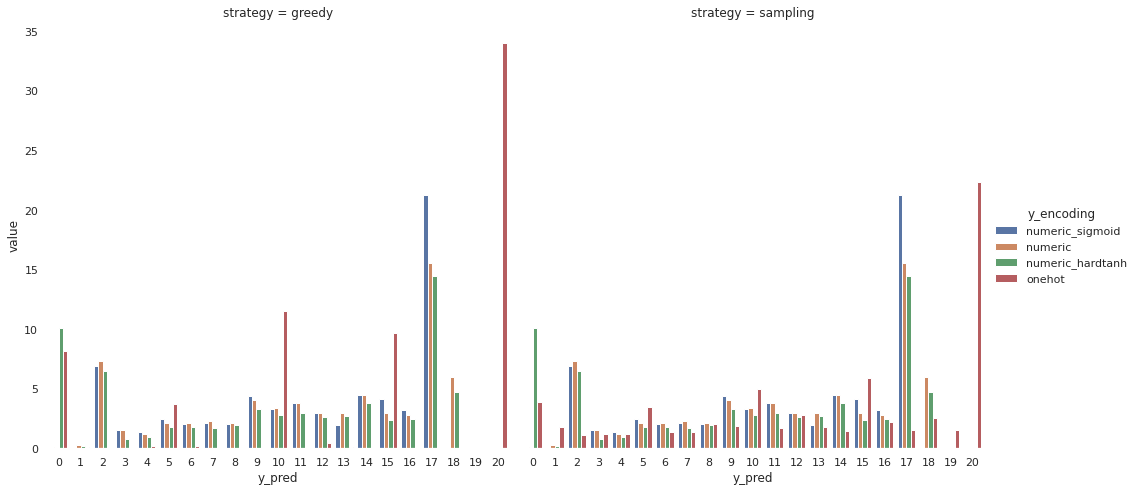

In [34]:
w = (
    (confusion_matrix_df['lr'] == '1.e-3') &
    (confusion_matrix_df['set'] == 'test')
)

sns.catplot(data=confusion_matrix_df[w], x='y_pred', y='value', hue='y_encoding', col='strategy', ci=None, kind='bar', height=7)

In the numeric encoding, the model is only taking actions that are a multiple of 5.

## Response surface

## 

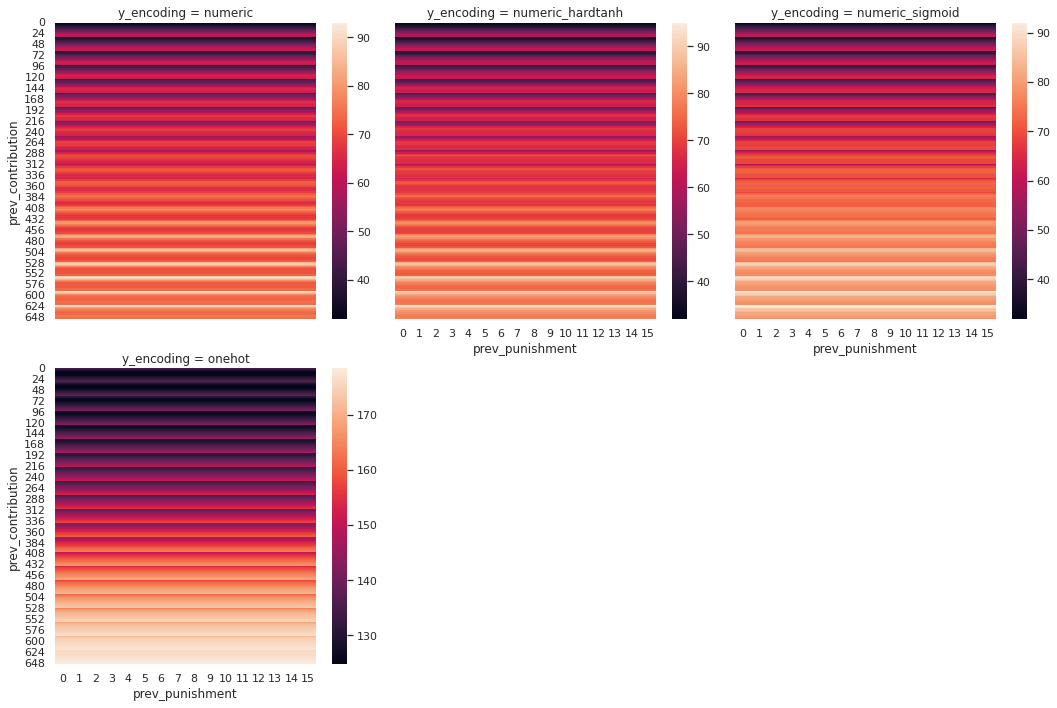

In [ ]:
selection = best_labels['accuracy'].copy()
df = synthethetic_df.copy()

focus_dimension = 'y_encoding'

selection.pop(focus_dimension)
# selection['regularisation'] = 'wd_1.e-6'

w = pd.concat(
    (df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

df = df[w]

# w2 = df[focus_dimension].isin(['none', 'wd_1.e-3', 'wd_1.e-4'])
# df = df[w2]

df = df.sort_values(focus_dimension)

if df['y_encoding'].unique()[0] == 'ordinal':
    df['exp_contribution'] = df['proba']
else:
    df['exp_contribution'] = df['contribution'] * df['proba']


def _plot_heatmap(data, x, y, values):
    dfg = data.groupby([x,y])['exp_contribution'].sum()
    dfg = dfg.reset_index()
    cm = dfg.pivot_table(index=x, columns=y, values=values)
    sns.heatmap(cm)

plot_heatmap = lambda data, color: _plot_heatmap(
    data, x='prev_contribution',y='prev_punishment', values='exp_contribution')

fg = sns.FacetGrid(df, col=focus_dimension, col_wrap=3, height=5)
fg.map_dataframe(plot_heatmap)

Numeric encoding is creating nicely smooth response surfaces. 